In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization, Conv2DTranspose, LeakyReLU, Reshape, ReLU, Input, Cropping2D
import tensorflow.keras.initializers
import time
import os
import matplotlib.pyplot as plt
from matplotlib import colors
from tensorflow.keras.models import Model, load_model
import math

In [6]:
numberOfExamples = 10
np.random.seed(seed = 2)
indices = np.random.randint(0, 10000, numberOfExamples)
print(indices)

[7336 2575 6637 2514 1099 4770  433 6751 2773 5167]


In [2]:
def testLayer():
    DIM = 64
    input_layer = Input(shape = 128)
    g = Dense(4*4*4*DIM, activation = 'relu')(input_layer)
    g = Reshape([4, 4, 4*DIM])(g)
    # he normal initializer used by gulrajani
    g = Conv2DTranspose(filters = 2*DIM, kernel_size = 5, strides = (2,2), padding = 'SAME', kernel_initializer = 'he_normal')(g)
    g = ReLU()(g)
    out = Cropping2D(cropping = ((0,1), (0,1)), data_format = 'channels_last')(g)
    model = Model(input_layer, out, name = 'Test')
    return model

In [3]:
testModel = testLayer()
testModel.summary()

Model: "Test"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128)]             0         
_________________________________________________________________
dense (Dense)                (None, 4096)              528384    
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 128)         819328    
_________________________________________________________________
re_lu (ReLU)                 (None, 8, 8, 128)         0         
_________________________________________________________________
cropping2d (Cropping2D)      (None, 7, 7, 128)         0         
Total params: 1,347,712
Trainable params: 1,347,712
Non-trainable params: 0
____________________________________________________

In [7]:
def makeGeneratorModel(latent_dim = 128):
    DIM = 64
    OUTPUT_DIM = 28*28
    input_layer = Input(shape = 128)
    g = Dense(4*4*4*DIM, activation = 'relu')(input_layer)
    g = Reshape([4, 4, 4*DIM])(g)
    # he normal initializer used by gulrajani
    g = Conv2DTranspose(filters = 2*DIM, kernel_size = 5, strides = (2,2), padding = 'SAME', kernel_initializer = 'he_normal')(g)
    g = ReLU()(g)
    g = Cropping2D(cropping = ((0,1), (0,1)), data_format = 'channels_last')(g)
    g = Conv2DTranspose(filters = DIM, kernel_size = 5, strides = (2,2), padding = 'SAME', kernel_initializer = 'he_normal')(g)
    g = ReLU()(g)
    output_layer = Conv2DTranspose(filters = 1, kernel_size = 5, strides = (2,2), padding = 'SAME', activation = 'sigmoid', kernel_initializer = 'he_normal')(g)
    #output_layer = Reshape([OUTPUT_DIM])(g)
    model = Model(input_layer, output_layer, name = 'Generator')
    return model

In [8]:
generator = makeGeneratorModel()
generator.summary()

Model: "Generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 4096)              528384    
_________________________________________________________________
reshape_1 (Reshape)          (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 8, 8, 128)         819328    
_________________________________________________________________
re_lu_1 (ReLU)               (None, 8, 8, 128)         0         
_________________________________________________________________
cropping2d_1 (Cropping2D)    (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 14, 14, 64)        20

In [11]:
def latent_vector(batchSize):
    vector = tf.random.normal(shape = [batchSize, 128])
    return vector

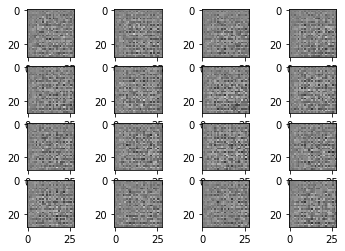

In [21]:
latentVec = latent_vector(16)
norm = colors.Normalize(vmin = 0, vmax = 1)
#print(latentVec)
generatedImages = generator(latentVec)
#print(generatedImages[0])
fig, ax = plt.subplots(4, 4)
for i in range(16):
    img = ax[math.floor(i/4), i%4].imshow(generatedImages[i,:,:,0], cmap = 'gray', interpolation = 'none')
    img.set_norm(norm)
#plt.savefig(exampleDir + '/img_at_epoch_{:04d}.png'.format(epoch))

In [22]:
def makeDiscriminatorModel():
    DIM = 64
    OUTPUT_DIM = 28*28
    input_layer = Input(shape = (28, 28, 1))
    d = Conv2D(filters = DIM, kernel_size = 5, strides = (2,2), padding = 'SAME')(input_layer)
    d = LeakyReLU()(d)
    d = Conv2D(filters = 2*DIM, kernel_size = 5, strides = (2,2), padding = 'SAME')(d)
    d = LeakyReLU()(d)
    d = Conv2D(filters = 4*DIM, kernel_size = 5, strides = (2,2), padding = 'SAME')(d)
    d = LeakyReLU()(d)
    d = Reshape([4*4*4*DIM])(d)
    d = Dense(1)(d)
    output_layer = Reshape([])(d)
    model = Model(input_layer, output_layer, name = 'Discriminator')
    return model

In [23]:
discriminator = makeDiscriminatorModel()
discriminator.summary()

Model: "Discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 256)         819456    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 4, 4, 256)       

In [29]:
def latent_vector(latent_dim, n):
    latent_input = np.random.randn(latent_dim * n)
    latent_input = latent_input.reshape(n, latent_dim)
    return latent_input

In [37]:
def latent_TF(latent_dim, batchSize):
    latent = tf.random.normal(shape = [batchSize, latent_dim])
    return latent

In [38]:
latentTest = latent_vector(128, 32)
print(latentTest.shape)

(32, 128)


In [39]:
latentTestTF = latent_TF(128, 32)
print(latentTestTF)

tf.Tensor(
[[ 0.7264999   1.2753634   0.45450193 ...  0.3560422   0.39970288
  -0.562689  ]
 [-0.94045687  0.20972656  0.54068166 ... -0.17981082 -0.6379695
   0.64622265]
 [-1.4109615   0.0313953  -0.01345648 ...  1.0031841   0.5973964
   0.13406664]
 ...
 [ 2.101613    0.16070576  0.310018   ... -0.43162882 -0.811249
  -0.37715527]
 [-0.17084184  0.426155    1.195737   ...  0.74254537  1.1825354
  -1.4439993 ]
 [ 1.2787826   0.5110079   0.10117753 ... -1.4355668  -0.39010403
   0.76352847]], shape=(32, 128), dtype=float32)


In [40]:
generatorOutput = generator(latentTestTF)
print(generatorOutput.shape)

(32, 28, 28, 1)


In [41]:
discriminatorOutput = discriminator(generatorOutput)
print(discriminatorOutput.shape)

(32,)


In [42]:
print(discriminatorOutput)

tf.Tensor(
[-0.00430636 -0.00985688 -0.01093845 -0.00831763 -0.01189218 -0.00410341
 -0.00616375 -0.00811315 -0.00467331 -0.0115303  -0.01046428 -0.0122214
 -0.00461306 -0.01106393 -0.00981379 -0.00849901 -0.00385295 -0.00769441
 -0.00633116 -0.00471729 -0.00916209 -0.00639037 -0.01086508 -0.00684429
 -0.00516949 -0.0064917  -0.00617127 -0.00216035 -0.00620425 -0.00690894
 -0.00874368 -0.00619763], shape=(32,), dtype=float32)


In [10]:
def makeInverterModel(latent_dim = 128):
        z_dim = latent_dim
        input_layer = Input(shape = (28, 28, 1))
        i = Conv2D(filters = latent_dim, kernel_size = 5, strides = (2,2), padding = 'SAME', kernel_initializer = 'he_normal')(input_layer)
        i = LeakyReLU()(i)
        i = Conv2D(filters = 2*latent_dim, kernel_size = 5, strides = (2,2), padding = 'SAME', kernel_initializer = 'he_normal')(i)
        i = LeakyReLU()(i)
        i = Conv2D(filters = 4*latent_dim, kernel_size = 5, strides = (2,2), padding = 'SAME', kernel_initializer = 'he_normal')(i)
        i = LeakyReLU()(i)
        i = Reshape([latent_dim * 64])(i)
        i = Dense(latent_dim * 8)(i)
        output_layer = Dense(z_dim)(i)
        model = Model(input_layer, output_layer, name = 'Inverter')
        return model

In [11]:
inverter = makeInverterModel()
inverter.summary()

Model: "Inverter"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 14, 128)       3328      
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 7, 7, 256)         819456    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 4, 4, 512)         3277312   
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 4, 4, 512)         0  

In [24]:
for i in range(16):
    print(i%4, math.floor(i/4))

0 0
1 0
2 0
3 0
0 1
1 1
2 1
3 1
0 2
1 2
2 2
3 2
0 3
1 3
2 3
3 3


In [7]:
# load mnist dataset
(X_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
img_data = X_train.copy()
img_data = img_data.reshape(X_train.shape[0], 28, 28, 1)
img_data = img_data / 255 #pixel values in [0,1]
test_data = x_test.copy()
test_data = test_data.reshape(x_test.shape[0], 28, 28, 1)
test_data = test_data / 255
test_images = test_data[indices]
print(test_images.shape)

(10, 28, 28, 1)


In [27]:
print(img_data.shape)

(60000, 28, 28, 1)


In [30]:
train_dataset = tf.data.Dataset.from_tensor_slices((img_data)).shuffle(60000).batch(32)

In [34]:
train_dataset.element_spec

TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float64, name=None)

In [41]:
# load mnist dataset
(X_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
img_data = X_train.copy()
img_data = img_data.reshape(X_train.shape[0], 28, 28, 1)
img_data = img_data / 255 #pixel values in [0,1]

In [42]:
print(img_data.shape)

(60000, 28, 28, 1)


In [43]:
batch = img_data[:32]
print(batch.shape)

(32, 28, 28, 1)


In [48]:
alpha = tf.random.uniform(shape = [32,1,1,1], minval = 0, maxval = 1)
tfbatch = tf.cast(batch, tf.float32)
mult = alpha * tfbatch
for i in range(32):
    tempMult = alpha[i] * tfbatch[i]
    if(np.all(mult[i] != tempMult)):
        print("false")
        break
#print(alpha[0], tfbatch[0], mult[0])

In [45]:
print(alpha[0])

tf.Tensor([[[0.60426986]]], shape=(1, 1, 1), dtype=float32)
